# Load geocoded h5 files using MintPy libraries

Gareth Funning, University of California, Riverside

It is pretty simple to use the MintPy libraries to open MintPy-produced h5 files!

## 0. Dependencies

Some fairly standard stuff here, covered by the earthscope_insar conda environment:

In [9]:
import matplotlib.pyplot as plt
from mintpy.utils import readfile, utils as ut
from osgeo import gdal, osr

## 1. Load the data and geometry

It is helpful to look at the various [data structures that MintPy uses](https://mintpy.readthedocs.io/en/latest/api/data_structure/) for this. We will use the MintPy readfile.read function for this. (It doesn't seem to have a documentation page, but there is an example [here](https://mintpy.readthedocs.io/en/latest/#23_build_on_top_of_mintpy_module).)

In [6]:
geodir='./geo/'    # path to the geocoded files

datafile='geo_velocity.h5'
geomfile='geo_geometryRadar.h5'

data, atr = readfile.read(geodir+datafile, datasetName='velocity')
azi, atr = readfile.read(geodir+geomfile, datasetName='azimuthAngle')
inc, atr = readfile.read(geodir+geomfile, datasetName='incidenceAngle')


## 2. Plot everything

How do you know if everything was loaded properly? You can plot it! Here we are going to use some [very simple matplotlib commands](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

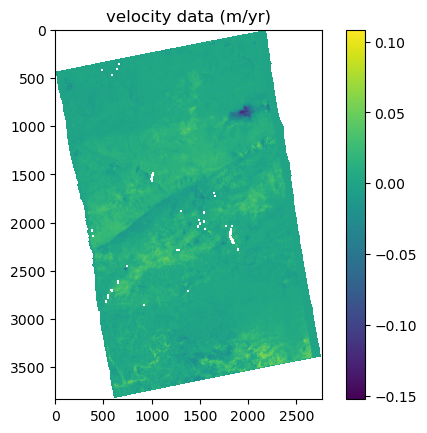

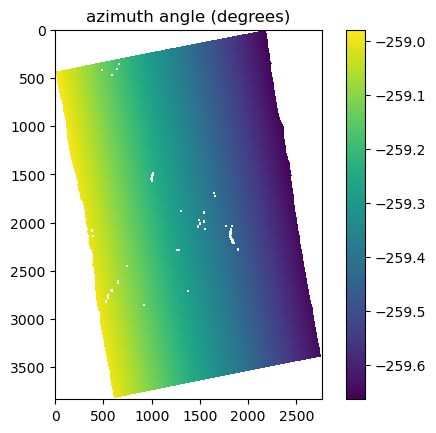

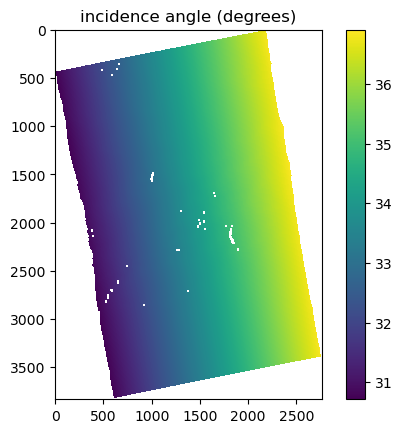

In [4]:
fig1, ax1 = plt.subplots()                       # initiate a matplotlib plot
im1 = ax1.imshow(data)                           # plot the 'data' array
ax1.set_title('velocity data (m/yr)')
fig1.colorbar(im1)                               # plot a color bar!

fig2, ax2 = plt.subplots()                       # initiate a matplotlib plot
im2 = ax2.imshow(azi)                            # plot the 'azi' array 
ax2.set_title('azimuth angle (degrees)')
fig2.colorbar(im2)                               # plot a color bar!

fig3, ax3 = plt.subplots()                       # initiate a matplotlib plot
im3 = ax3.imshow(inc)                            # plot the 'inc' array
ax3.set_title('incidence angle (degrees)')
fig3.colorbar(im3)                               # plot a color bar!


plt.show();

## 3. Extract locations from the metadata

We just loaded in the location information as a by-product of loading in the data. We can use that to locate ourselves...

In [8]:
# extract lat/lon information from the attributes
lat0 = float(atr['Y_FIRST']);  lat_step = float(atr['Y_STEP']);  lat_num = int(atr['LENGTH'])
lon0 = float(atr['X_FIRST']);  lon_step = float(atr['X_STEP']);  lon_num = int(atr['WIDTH'])
lat1 = lat0 + lat_step * lat_num
lon1 = lon0 + lon_step * lon_num

print('longitude range: {0:f} to {1:f}'.format(lon0,lon1))
print('latitude range: {0:f} to {1:f}'.format(lat1,lat0))

longitude range: 38.416115 to 39.722604
latitude range: 37.579124 to 38.910059


## 4. Want to write them out as geotiffs?

PyGMT doesn't seem to like reading in the h5 files, perhaps it can't interpret them properly. But we can export the data we just loaded in a format PyGMT can handle, using the gdal libraries.

In [12]:
# some file names
outdata='geo_velocity'
outazi='geo_azimuthAngle'
outinc='geo_incidenceAngle'

# try to write out the velocity data in GeoTiff format
driver = gdal.GetDriverByName("GTiff")
outgrd = driver.Create(geodir+outdata+'.tiff', lon_num, lat_num, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((lon0, lon_step, 0, lat0, 0, lat_step))
outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(4326)
outgrd.SetProjection(outgrdSRS.ExportToWkt())
outband = outgrd.GetRasterBand(1)
outband.WriteArray(data,0,0)
outband.FlushCache()         # need this to actually write anything!
outband.SetNoDataValue(0)
del outgrd, outband, outgrdSRS

# and again for the azimuth angles
driver = gdal.GetDriverByName("GTiff")
outgrd = driver.Create(geodir+outazi+'.tiff', lon_num, lat_num, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((lon0, lon_step, 0, lat0, 0, lat_step))
outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(4326)
outgrd.SetProjection(outgrdSRS.ExportToWkt())
outband = outgrd.GetRasterBand(1)
outband.WriteArray(azi,0,0)
outband.FlushCache()
outband.SetNoDataValue(0)
del outgrd, outband, outgrdSRS

# and again for the incidence angles
driver = gdal.GetDriverByName("GTiff")
outgrd = driver.Create(geodir+outinc+'.tiff', lon_num, lat_num, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((lon0, lon_step, 0, lat0, 0, lat_step))
outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(4326)
outgrd.SetProjection(outgrdSRS.ExportToWkt())
outband = outgrd.GetRasterBand(1)
outband.WriteArray(inc,0,0)
outband.FlushCache()
outband.SetNoDataValue(0)
del outgrd, outband, outgrdSRS